# Initialize imports

In [1]:
import json
import math
import os

from keras.backend import clear_session
import matplotlib.pyplot as plt
import numpy as np

from abyss_deep_learning.datasets.coco import ImageClassificationDataset
from abyss_deep_learning.datasets.translators import CocoCaptionTranslator
from abyss_deep_learning.keras.classification import caption_map_gen, onehot_gen, hamming_loss
from abyss_deep_learning.keras.utils import lambda_gen, batching_gen
from abyss_deep_learning.keras.models import ImageClassifier
from abyss_deep_learning.utils import balanced_set

Using TensorFlow backend.


# Directory paths

In [2]:
# DATA_DIR = "/mnt/ssd1/processed/industry-data/project-max/ml/cloud-factory-data/with-bg/multi-label-datasets
# /forwards/notebook-ready"

DATA_DIR = "/home/users/khu/src/abyss/project-max/ml/cloud-factory-data/with-bg/multi-label-datasets/both/notebook-ready"

DIR_NAME = os.path.dirname(os.path.realpath('__file__'))
IM_DIR = os.path.join(DIR_NAME, "../../../../project-max/all-images")

# Correct image paths in train json file 
# Count occurrences of classes for multi label

In [3]:
with open(os.path.join(DATA_DIR, "train-nb.json"), 'r') as json_file:
    data = json.load(json_file)

for image in (data["images"]):
    image_name = image['path'].rpartition('/')
    image['path'] = os.path.join(IM_DIR, image_name[2])
    
caption_count = {}
    
for ann in data["annotations"]:
    for cap in ann['caption'].split(','):
        if cap not in caption_count:
            caption_count[cap] = 0
        caption_count[cap] += 1

with open(os.path.join(DATA_DIR, "train-nb.json"), 'w') as json_file:
    json.dump(data, json_file, indent=4)

## Count of all classes in training set

In [4]:
print(caption_count)

{'ED': 4359, 'BG': 800, 'IP': 6521, 'JD': 1077, 'C': 836}


In [5]:
total = sum(caption_count.values())
caption_pct = {}
for key, value in caption_count.items():
    caption_pct[key] = value / total * 100
print(caption_pct)

{'ED': 32.067976164202165, 'BG': 5.885382182005444, 'IP': 47.97322151107187, 'JD': 7.923195762524829, 'C': 6.150224380195689}


# Correct images paths in validation json file

In [6]:
with open(os.path.join(DATA_DIR, "val-nb.json"), 'r') as json_file:
    data = json.load(json_file)

for image in (data["images"]):
    image_name = image['path'].rpartition('/')
    image['path'] = os.path.join(IM_DIR, image_name[2])

with open(os.path.join(DATA_DIR, "val-nb.json"), 'w') as json_file:
    json.dump(data, json_file, indent=4)

# Load annotations into memory

In [7]:
train_ds = ImageClassificationDataset(
    os.path.join(DATA_DIR, "train-nb.json"),
    image_dir=DATA_DIR,
    cached=False,
    translator=CocoCaptionTranslator(separator=","))

<class 'abyss_deep_learning.datasets.translators.CocoCaptionTranslator'>


loading annotations into memory...
Done (t=0.03s)
creating index...
index created!


In [8]:
balanced = list(balanced_set(train_ds.coco))

In [9]:
train_ds._calc_class_stats()
print(train_ds.captions)
train_ds.class_weights

{'IP', 'ED', 'BG', 'JD', 'C'}


{0: 0.417, 1: 0.624, 2: 3.398, 3: 2.524, 4: 3.252}

In [10]:
val_ds = ImageClassificationDataset(
    os.path.join(DATA_DIR, "val-nb.json"),
    image_dir=DATA_DIR,
    cached=False,
    translator=CocoCaptionTranslator(separator=','))

<class 'abyss_deep_learning.datasets.translators.CocoCaptionTranslator'>


loading annotations into memory...
Done (t=0.07s)
creating index...
index created!


In [11]:
val_ds._calc_class_stats()
print(val_ds.captions)

{'IP', 'ED', 'BG', 'JD', 'C'}


# Caption map for one hot gen

In [12]:
caption_map = {key: i for i, key in enumerate(caption_count)}
print(caption_map)

{'ED': 0, 'BG': 1, 'IP': 2, 'JD': 3, 'C': 4}


# Reverse caption map to determine what class an integer represents

In [13]:
caption_map_r = {val: key for key, val in caption_map.items()}
print(caption_map_r)

{0: 'ED', 1: 'BG', 2: 'IP', 3: 'JD', 4: 'C'}


# Determine class weights to penalize frequently occurring classes

In [14]:
class_weights =  1 / np.array([j**2 for i, j in sorted(caption_count.items(), key=lambda x: x[0])], dtype=np.float32)
class_weights /= np.linalg.norm(class_weights)
class_weights = dict(zip(sorted(caption_count.keys()), class_weights.tolist()))

for key in caption_map:
    class_weights[caption_map[key]] = class_weights.pop(key)

print("class_weights:")
print(class_weights)

class_weights:
{0: 0.023001570254564285, 1: 0.682890772819519, 2: 0.010277863591909409, 3: 0.3767904043197632, 4: 0.6253435611724854}


# Define pipeline for the generators

In [15]:
def pipeline(gen, caption_map):
    """ Pipeline consists of lambda expression mapping x -> x, and y to become a set of comma separated captions
        i.e.  {'ED,IP'} -> {'ED', 'IP'}
        caption_map_gen converts caption labels to numeric integers
        onehot_gen converts numeric integers to a vector of 1's and 0's where 1 is a given label
    """
    return onehot_gen(
        caption_map_gen(
            lambda_gen(gen, lambda x, y: (x, set(y.pop().split(',')))),
            caption_map
        ),
        len(caption_map)
    )

def create_new_model():
    clear_session()
    model = ImageClassifier(
        backbone='xception', input_shape=(None, None, 3), classes=5,
        init_lr=1e-5, init_weights='imagenet',
        trainable=True, loss='binary_crossentropy', output_activation='sigmoid',
        metrics=['accuracy', hamming_loss]
    )
    return model

# Process 100 images 1 by 1 per epoch for 10 epochs

# Cross validate on 100 samples

In [16]:
batch_size = 1
#steps_per_epoch = math.floor(len(train_ds.coco.getImgIds()) / batch_size)
steps_per_epoch = 100

model = create_new_model()
print("Break-even loss is", -np.log(1 / model.classes))
model.save_on_epoch_end()
model.fit_generator(batching_gen(pipeline(train_ds.generator(data_ids=balanced,shuffle_ids=True), caption_map), batch_size=batch_size),
                    validation_data=batching_gen(pipeline(val_ds.generator(endless=True), caption_map), batch_size=batch_size), 
                    validation_steps=100,
                    epochs=10, 
                    use_multiprocessing=True,
                    steps_per_epoch=steps_per_epoch,
                    verbose=1)

Break-even loss is 1.6094379124341003


/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function caption_map_gen is deprecated; Use the new dataset translators interface.
  warnings.warn(msg, category=DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function onehot_gen is deprecated; Use the new dataset translators interface.
  warnings.warn(msg, category=DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function caption_map_gen is deprecated; Use the new dataset translators interface.
  warnings.warn(msg, category=DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function onehot_gen is deprecated; Use the new dataset translators interface.
  warnings.warn(msg, category=DeprecationWarning)


Epoch 1/10
100/100 [==============================] - 37s 365ms/step - loss: 0.6500 - acc: 0.7720 - hamming_loss: 0.4768 - val_loss: 0.6027 - val_acc: 0.7960 - val_hamming_loss: 0.4486

Epoch 00001: val_loss improved from inf to 0.60270, saving model to ./logs/weights_epoch:01-val_loss:0.60.hdf5
Epoch 2/10
100/100 [==============================] - 29s 292ms/step - loss: 0.5884 - acc: 0.8000 - hamming_loss: 0.4387 - val_loss: 0.5144 - val_acc: 0.8000 - val_hamming_loss: 0.3700

Epoch 00002: val_loss improved from 0.60270 to 0.51437, saving model to ./logs/weights_epoch:02-val_loss:0.51.hdf5
Epoch 3/10
100/100 [==============================] - 29s 289ms/step - loss: 0.5237 - acc: 0.8000 - hamming_loss: 0.3873 - val_loss: 0.5763 - val_acc: 0.8000 - val_hamming_loss: 0.3632

Epoch 00003: val_loss did not improve from 0.51437
Epoch 4/10
100/100 [==============================] - 30s 303ms/step - loss: 0.4741 - acc: 0.8000 - hamming_loss: 0.3362 - val_loss: 0.5037 - val_acc: 0.8000 - val_h

ImageClassifier(backbone='xception', classes=5, init_epoch=0, init_lr=1e-05,
        init_weights='imagenet', input_shape=(None, None, 3),
        loss='binary_crossentropy',
        metrics=['accuracy', <function hamming_loss at 0x7fb47f088158>],
        output_activation='sigmoid', pooling='avg', trainable=True)

In [24]:
print(model.history.validation_data)

None


In [18]:
model.model_.load_weights('./logs/weights_epoch:01-val_loss:0.39.hdf5')

Predictions (%)
[0.19391352 0.10314468 0.6428062  0.10021936 0.12342559]
Actual
[0]


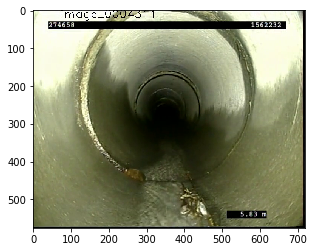

In [19]:
val_image, val_labels = val_ds.sample()

print("Predictions (%)")
print(model.predict_proba(np.expand_dims(val_image, axis=0))[0])
print("Actual")
print([caption_map[x] for x in val_labels])
plt.imshow(val_ds.sample()[0])